<div style="display: flex; align-items: center; justify-content: center; text-align: center;">
 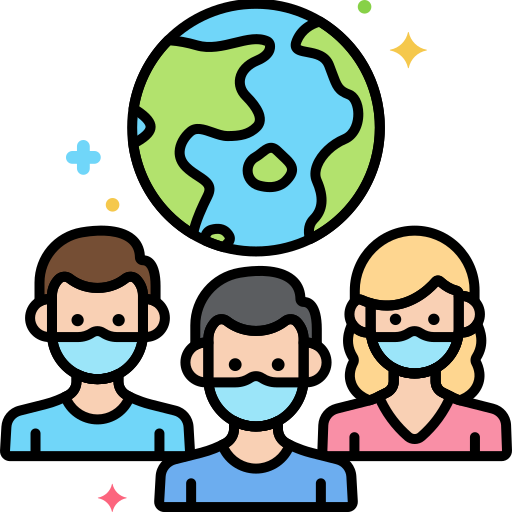
<div>
     <h1><b>Identifying Key Factors Influencing Variant Severity</b></h1>
  </div>
</div>

## Problem Statement 

 **Goal**: Analyze Covid-19 public health dataset to determine which factors contribute to a variant being more severe.

Background : This dataset contains records related to different COVID-19 variants detected across various countries. It provides key epidemiological insights, including the number of cases, deaths, recoveries, and hospitalizations for each variant. Additionally, it includes transmission rates, mutation counts, and severity levels. The dataset can be useful for analyzing the spread and impact of different variants over time. This dataset is a consolidated version combining variant-related data reported globally. It helps in understanding the patterns of transmission, mutation trends, and severity levels associated with different COVID-19 strains. Click [here](https://www.kaggle.com/datasets/kushagraddata/covid-pandemic-varients) for the data dictonary


### World Health DataSet

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.io as pio
import xgboost as xgb

from sklearn.model_selection import train_test_split, RandomizedSearchCV, train_test_split
from sklearn import metrics
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, classification_report, accuracy_score, ConfusionMatrixDisplay, mean_absolute_error
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LinearRegression

pio.renderers.default = 'notebook'

## Exploratory Data Analysis (EDA) 🧮

In [9]:
covid = pd.read_csv('data/covid_variants.csv')
covid.sort_values('Date_Detected').head()

,Variant,Country,Date_Detected,Cases,Deaths,Recovered,Hospitalized,Transmission_Rate,Mutation_Count,Severity_Level
169,Beta,Australia,2020-01-09,69724,1422,66456,1363,1.04,1,Mild
985,Delta,USA,2020-01-11,31231,3155,28671,9918,2.41,12,Critical
403,Omicron,Germany,2020-01-11,10158,4117,18866,281,1.81,8,Severe
599,Alpha,France,2020-01-14,76121,3670,25983,2691,1.14,11,Severe
375,Epsilon,Australia,2020-01-14,3860,2606,30316,7219,0.83,12,Mild


In [10]:
covid.isnull().sum()

Variant              0
Country              0
Date_Detected        0
Cases                0
Deaths               0
Recovered            0
Hospitalized         0
Transmission_Rate    0
Mutation_Count       0
Severity_Level       0
dtype: int64

In [11]:
covid.describe()

,Cases,Deaths,Recovered,Hospitalized,Transmission_Rate,Mutation_Count
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,49217.413000,2574.546000,47788.435000,4970.183000,1.715070,10.023000
std,28789.556442,1427.131865,27632.058466,2912.573549,0.733849,5.414221
min,238.000000,2.000000,337.000000,11.000000,0.500000,1.000000
25%,23554.250000,1346.250000,23541.000000,2423.750000,1.080000,6.000000
50%,50199.000000,2657.000000,47390.000000,4940.000000,1.690000,10.000000
75%,74759.250000,3727.250000,71649.250000,7400.750000,2.360000,15.000000
max,99921.000000,4997.000000,94963.000000,9984.000000,3.000000,19.000000


In [12]:
covid.columns = covid.columns.str.lower()
covid

,variant,country,date_detected,cases,deaths,recovered,hospitalized,transmission_rate,mutation_count,severity_level
0,Mu,USA,2022-03-19,38091,232,15458,1476,1.27,10,Moderate
1,Delta,Canada,2021-06-29,79157,1552,58030,3967,1.16,7,Moderate
2,Epsilon,UK,2022-07-18,7071,3270,83006,1976,2.24,14,Mild
3,Omicron,UK,2020-08-30,29239,2409,16401,385,0.98,16,Moderate
4,Mu,Germany,2023-09-29,85545,3512,4181,272,0.73,15,Severe
...,...,...,...,...,...,...,...,...,...,...
995,Theta,Brazil,2023-08-14,74807,903,83213,8017,1.80,11,Critical
996,Theta,Japan,2022-03-26,78357,861,71282,1651,2.17,18,Critical
997,Epsilon,Germany,2023-08-22,61315,1083,49044,481,2.54,18,Moderate
998,Beta,India,2023-10-10,55935,649,79129,2950,1.15,10,Moderate


In [13]:
covid.dtypes

variant               object
country               object
date_detected         object
cases                  int64
deaths                 int64
recovered              int64
hospitalized           int64
transmission_rate    float64
mutation_count         int64
severity_level        object
dtype: object

In [14]:
covid['date_datetime'] = pd.to_datetime(covid['date_detected'])

In [15]:
covid['date_datetime'] = pd.to_datetime(covid['date_datetime'])

In [16]:
covid['month_year'] = covid['date_datetime'].dt.strftime('%Y-%m')

In [17]:
covid.drop(columns =['date_detected', 'date_datetime'], inplace = True)


In [18]:
covid = covid.sort_values('month_year')

In [19]:
'''Calculating case fatality rate
Higher values indicate more deadly variants.'''
covid['case_fatality_rate'] = covid['deaths']/covid['cases']*100
covid['case_fatality_rate']

609     0.954198
659     6.458621
700     4.845299
908     2.312840
640    10.555977
         ...    
728     3.593718
131     1.389057
815     1.909659
513     3.671580
866     9.068207
Name: case_fatality_rate, Length: 1000, dtype: float64

In [20]:
'''Hospitalization Rate
Hospitalization rates are calculated as the number of residents in a surveillance 
area who are hospitalized with laboratory-confirmed COVID-19, 
divided by the total population estimate for that area, or in this case "cases".'''

covid['hospitalized_rate']= covid['hospitalized']/covid['cases']*100
covid['hospitalized_rate']

609     2.241257
659     4.137921
700     7.750951
908    10.724040
640    42.684513
         ...    
728     9.019344
131    67.834280
815     5.008827
513    16.990369
866    23.245409
Name: hospitalized_rate, Length: 1000, dtype: float64

In [21]:
'''Recovery Rate
Indicates how mild/severe a variant is.'''
covid['recovery_rate']= covid['recovered']/covid['cases']*100
covid['recovery_rate']

609     40.795313
659     56.915128
700    106.755673
908     97.231939
640     25.663813
          ...    
728     89.985846
131    252.590893
815     97.227282
513    148.603203
866    138.962593
Name: recovery_rate, Length: 1000, dtype: float64

In [22]:
'''Variant Prevalence in Country, Percentage of total cases in each country for each variant
Helps understand which variant dominated in each region.'''

# Calculate total cases per country
total_cases_per_country = covid.groupby('country')['cases'].transform('sum')
total_cases_per_country

# Calculate variant prevalence in each country (%)
covid["variant_prevalence"] = (covid["cases"] / total_cases_per_country) * 100
covid["variant_prevalence"]

609    1.344836
659    1.345284
700    1.570374
908    1.236301
640    0.368834
         ...   
728    1.586452
131    0.201958
815    1.523957
513    0.373891
866    0.719140
Name: variant_prevalence, Length: 1000, dtype: float64

In [23]:
'''Mutation-to-Transmission Ratio 
Helps assess if more mutations lead to increased spread.'''

covid['mutation_transmission_ratio']= covid['mutation_count']/covid['transmission_rate']
covid['mutation_transmission_ratio']

609     2.521008
659     2.439024
700     5.617978
908    13.333333
640     0.757576
         ...    
728    12.048193
131     8.755760
815     2.766798
513    18.421053
866     0.374532
Name: mutation_transmission_ratio, Length: 1000, dtype: float64

In [24]:
# Helps capture the combined effect of mutations and spreadability
covid["mutation_transmission_interaction"] = covid["mutation_count"] * covid["transmission_rate"]
covid["mutation_transmission_interaction"]

609    14.28
659    10.25
700    17.80
908     7.50
640     1.32
       ...  
728     8.30
131    41.23
815    17.71
513    10.64
866     2.67
Name: mutation_transmission_interaction, Length: 1000, dtype: float64

In [25]:
covid = pd.get_dummies(covid, columns=["variant"], dtype=int, drop_first=True)

In [26]:
covid

,country,cases,deaths,recovered,hospitalized,transmission_rate,mutation_count,severity_level,month_year,case_fatality_rate,...,mutation_transmission_interaction,variant_Beta,variant_Delta,variant_Epsilon,variant_Gamma,variant_Lambda,variant_Mu,variant_Omicron,variant_Theta,variant_Zeta
609,Australia,67596,645,27576,1515,2.38,6,Moderate,2020-01,0.954198,...,14.28,0,0,1,0,0,0,0,0,0
659,Brazil,68126,4400,38774,2819,2.05,5,Mild,2020-01,6.458621,...,10.25,0,0,0,0,0,0,1,0,0
700,India,78571,3807,83879,6090,1.78,10,Mild,2020-01,4.845299,...,17.80,0,0,0,0,0,1,0,0,0
908,Brazil,62607,1448,60874,6714,0.75,10,Critical,2020-01,2.312840,...,7.50,0,0,0,1,0,0,0,0,0
640,India,18454,1948,4736,7877,1.32,1,Severe,2020-01,10.555977,...,1.32,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
728,South Africa,74185,2666,66756,6691,0.83,10,Severe,2023-12,3.593718,...,8.30,1,0,0,0,0,0,0,0,0
131,UK,8279,115,20912,5616,2.17,19,Mild,2023-12,1.389057,...,41.23,0,0,0,0,0,1,0,0,0
815,France,71374,1363,69395,3575,2.53,7,Mild,2023-12,1.909659,...,17.71,1,0,0,0,0,0,0,0,0
513,Australia,18793,690,27927,3193,0.76,14,Moderate,2023-12,3.671580,...,10.64,0,1,0,0,0,0,0,0,0


In [27]:
covid.describe()

,cases,deaths,recovered,hospitalized,transmission_rate,mutation_count,case_fatality_rate,hospitalized_rate,recovery_rate,variant_prevalence,...,mutation_transmission_interaction,variant_Beta,variant_Delta,variant_Epsilon,variant_Gamma,variant_Lambda,variant_Mu,variant_Omicron,variant_Theta,variant_Zeta
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,...,1000.000000,1000.00000,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,49217.413000,2574.546000,47788.435000,4970.183000,1.715070,10.023000,16.282587,35.834658,335.450791,1.000000,...,17.193710,0.08300,0.094000,0.10000,0.110000,0.096000,0.094000,0.107000,0.107000,0.091000
std,28789.556442,1427.131865,27632.058466,2912.573549,0.733849,5.414221,49.390641,153.253370,1181.630934,0.587469,...,12.602369,0.27602,0.291975,0.30015,0.313046,0.294739,0.291975,0.309268,0.309268,0.287753
min,238.000000,2.000000,337.000000,11.000000,0.500000,1.000000,0.006051,0.020670,0.374723,0.005022,...,0.530000,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,23554.250000,1346.250000,23541.000000,2423.750000,1.080000,6.000000,2.885558,4.917339,47.358851,0.484286,...,6.885000,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,50199.000000,2657.000000,47390.000000,4940.000000,1.690000,10.000000,5.393726,10.045960,96.386610,1.020760,...,14.410000,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,74759.250000,3727.250000,71649.250000,7400.750000,2.360000,15.000000,10.199654,19.927423,192.983189,1.508676,...,24.750000,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,99921.000000,4997.000000,94963.000000,9984.000000,3.000000,19.000000,909.170306,2808.494208,18377.074236,2.430422,...,55.670000,1.00000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [28]:
covid.isnull().sum()

country                              0
cases                                0
deaths                               0
recovered                            0
hospitalized                         0
transmission_rate                    0
mutation_count                       0
severity_level                       0
month_year                           0
case_fatality_rate                   0
hospitalized_rate                    0
recovery_rate                        0
variant_prevalence                   0
mutation_transmission_ratio          0
mutation_transmission_interaction    0
variant_Beta                         0
variant_Delta                        0
variant_Epsilon                      0
variant_Gamma                        0
variant_Lambda                       0
variant_Mu                           0
variant_Omicron                      0
variant_Theta                        0
variant_Zeta                         0
dtype: int64

In [29]:
covid.dtypes

country                               object
cases                                  int64
deaths                                 int64
recovered                              int64
hospitalized                           int64
transmission_rate                    float64
mutation_count                         int64
severity_level                        object
month_year                            object
case_fatality_rate                   float64
hospitalized_rate                    float64
recovery_rate                        float64
variant_prevalence                   float64
mutation_transmission_ratio          float64
mutation_transmission_interaction    float64
variant_Beta                           int64
variant_Delta                          int64
variant_Epsilon                        int64
variant_Gamma                          int64
variant_Lambda                         int64
variant_Mu                             int64
variant_Omicron                        int64
variant_Th

## EDA Visuals 📊

In [31]:
corr = covid.corr(numeric_only = True)
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

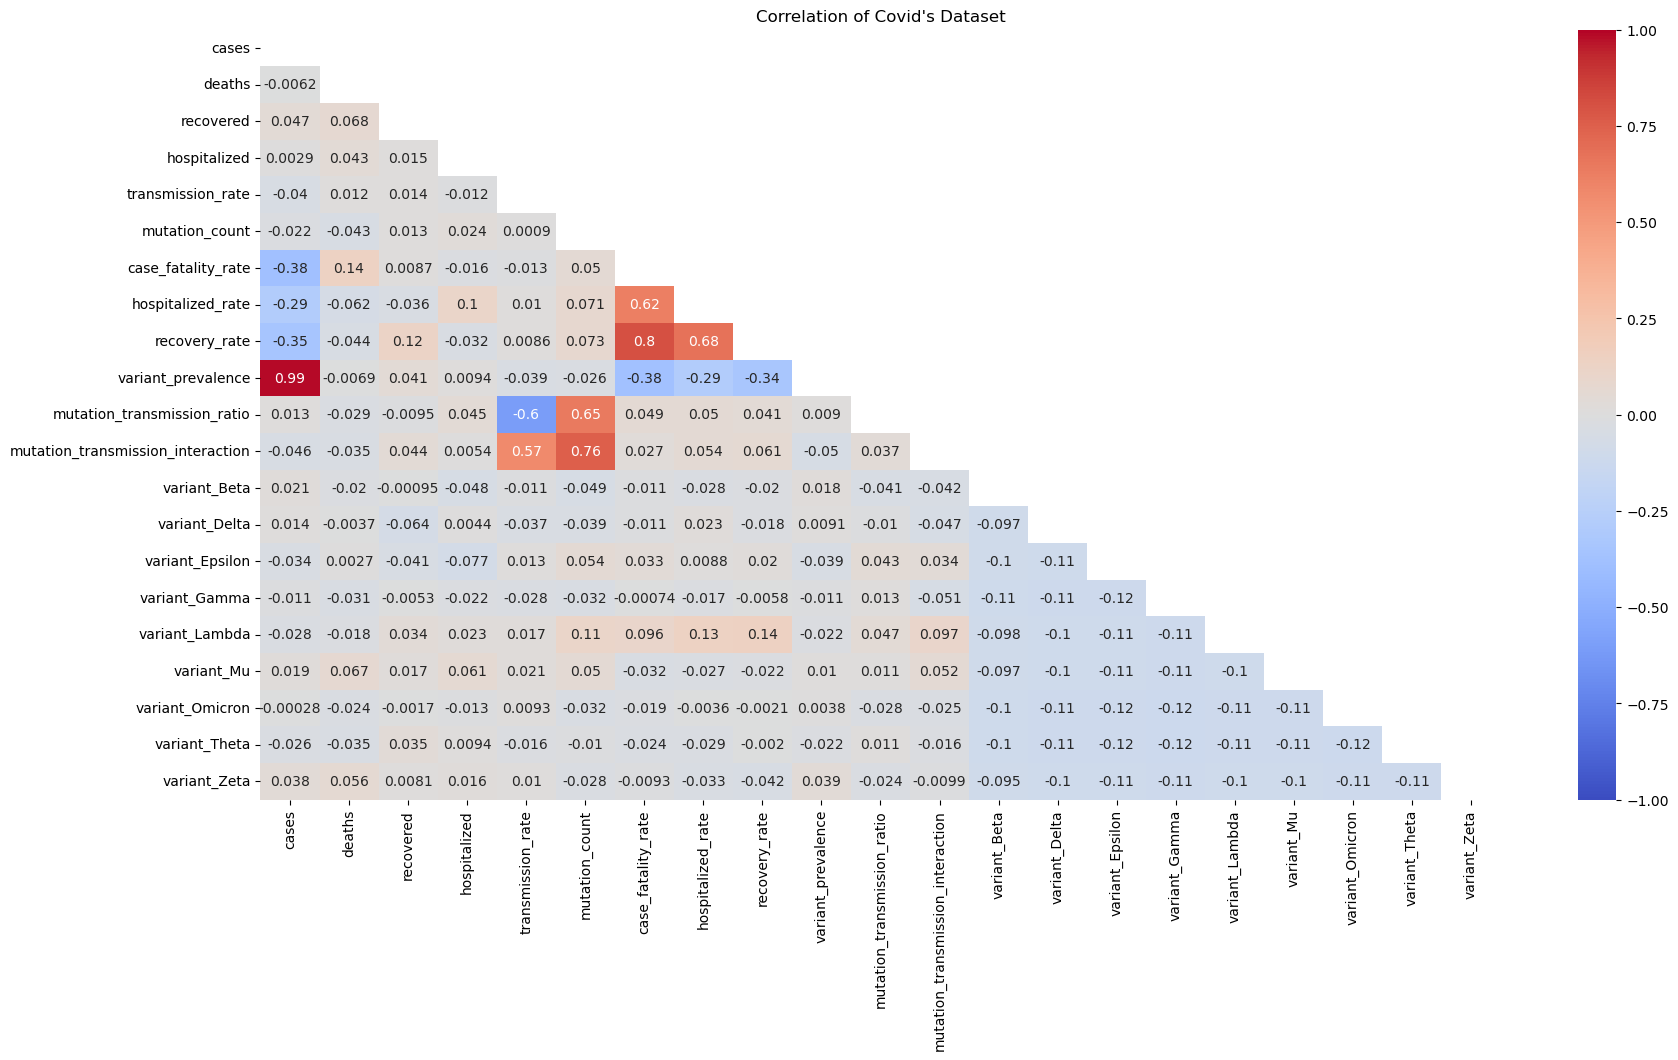

In [32]:
plt.figure(figsize = (20,10))
sns.heatmap(covid.corr(numeric_only = True),
            vmin = -1,
            vmax = 1,
            cmap = 'coolwarm',
            annot = True,
            mask = mask);

plt.title("Correlation of Covid's Dataset");

> This heatmap helps us identify which factors contribute most to COVID-19 variant severity, guiding us in building a predictive model. It shows that higher fatality and hospitalization rates strongly correlate with severity, meaning variants with these traits are more dangerous. It also highlights strong positive correlations that should be used as key features in a machine learning model. By training a Random Forest Regressor with these features, we can predict how severe a new variant might be before it spreads widely. This helps health officials prepare hospitals, allocate resources, and issue early warnings based on predicted severity levels. Ultimately, the heatmap acts as a data driven decision making tool for both researchers and policymakers, enabling better pandemic response and risk assessment.

In [34]:
covid.groupby('severity_level')['transmission_rate'].mean().sort_values

<bound method Series.sort_values of severity_level
Critical    1.684647
Mild        1.724808
Moderate    1.686667
Severe      1.763482
Name: transmission_rate, dtype: float64>

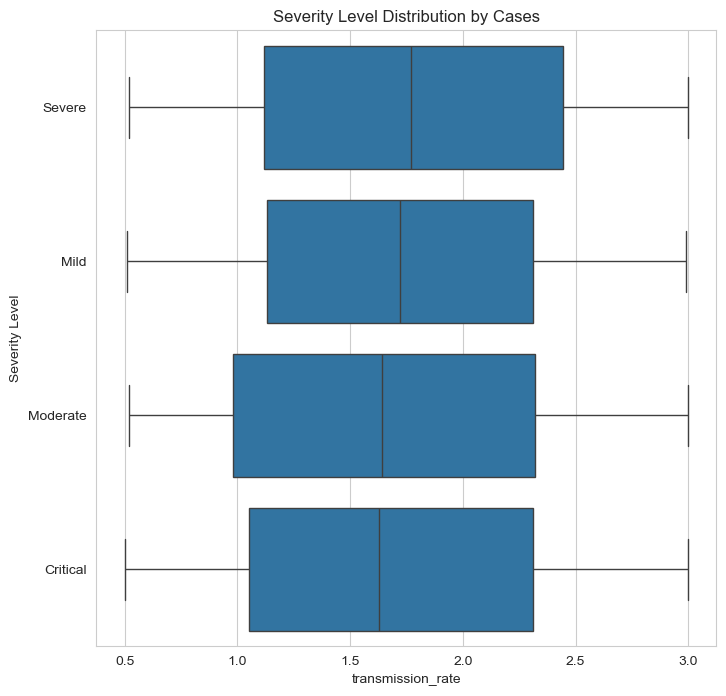

In [35]:
sns.set_style('whitegrid')

#Boxplot of our feaure
plt.figure(figsize = (8,8))
sns.boxplot(data = covid,
            y = 'severity_level',
            x = 'transmission_rate',
            order = covid.groupby('severity_level')['transmission_rate'].mean().sort_values(ascending = False).index)

plt.title("Severity Level Distribution by Cases")
plt.xlabel("transmission_rate")
plt.ylabel("Severity Level")
plt.show();

> This boxplot helps us to visualize how transmission rate varies across different severity levels of COVID-19 variants.  This plot reveals the distribution, median, and outliers of transmission rates for each severity level, allowing us to detect patterns that can improve feature selection in predictive modeling. If higher transmission rates are consistently linked to severe variants, then transmission rate should be included as a key predictor in a machine learning model. This insight enables health organizations to predict which new variants might be severe based on their transmission rate, even before enough hospitalization data is available. 

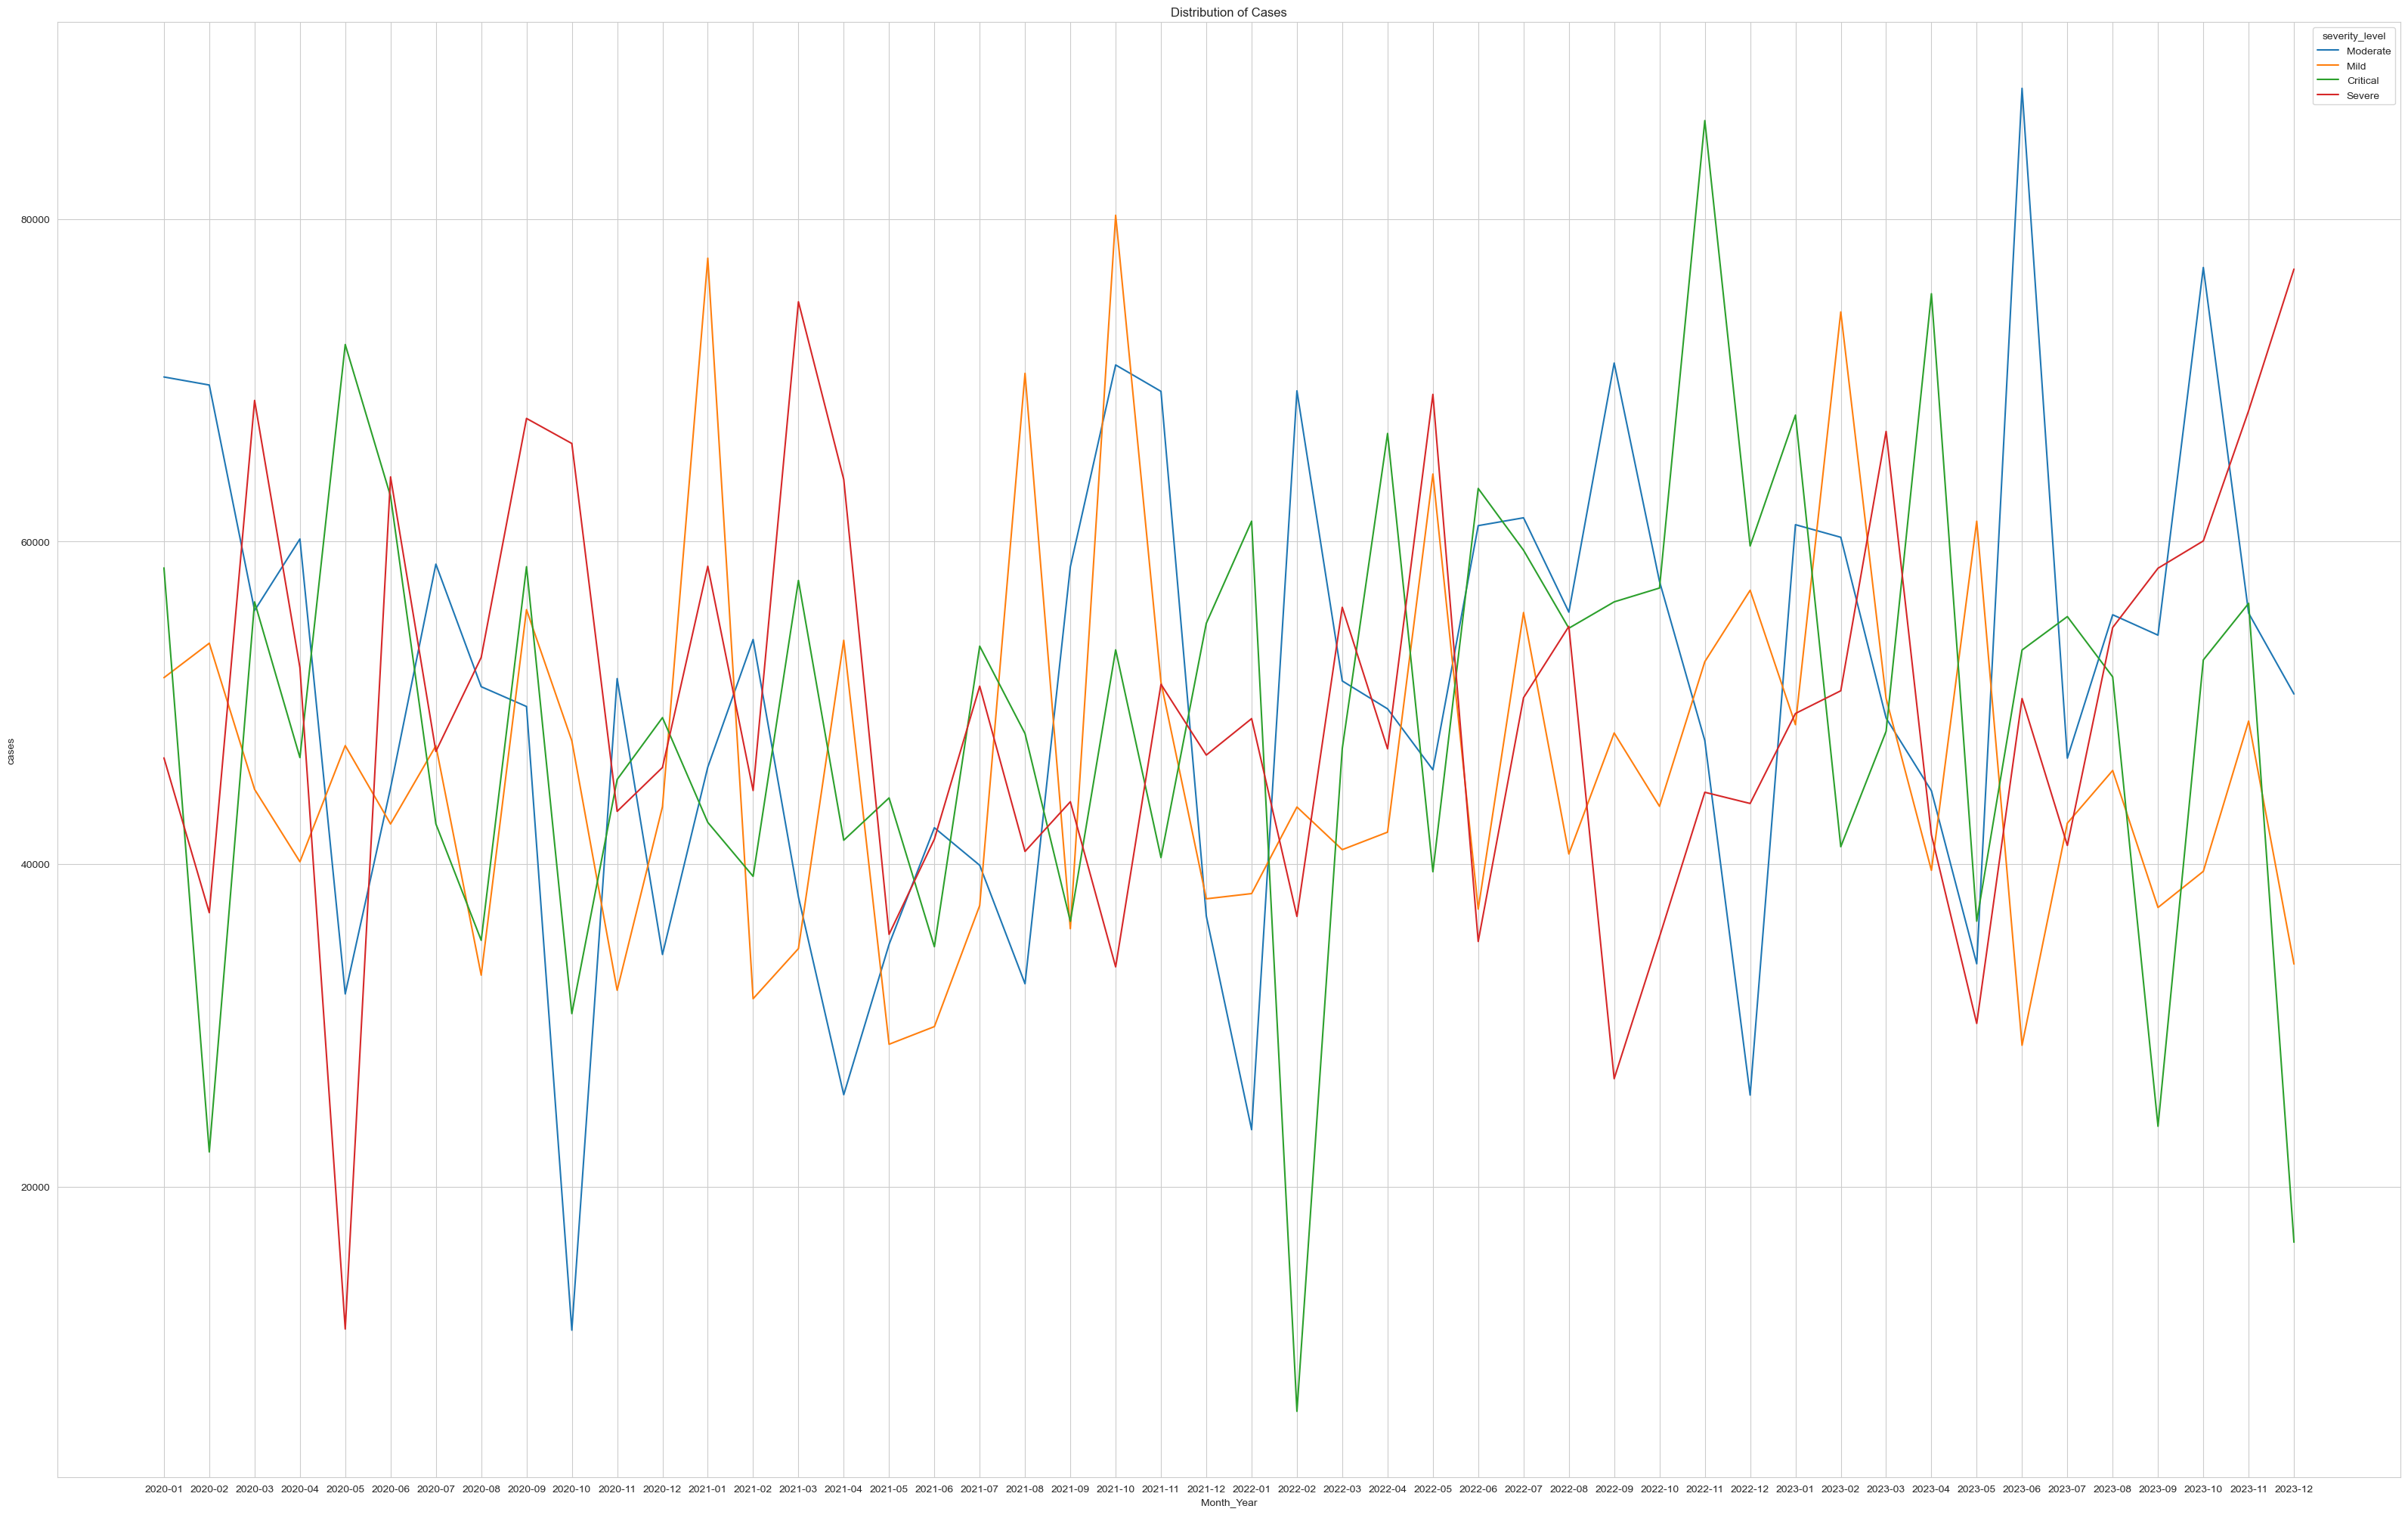

In [37]:
plt.figure(figsize = (40,25))

sns.lineplot(data = covid,
              x = 'month_year',
              y = 'cases',
              hue = 'severity_level',
              errorbar =None);

sns.set(style = None)
plt.title('Distribution of Cases')
plt.xlabel('Month_Year')
plt.show();

> This line plot shows how COVID-19 case trends change over time and how they relate to different severity levels. This highlights time-series trends, showing whether higher case counts correlate with more severe variants, which can improve predictive modeling.

In [39]:
fig = px.scatter_3d(covid,
                    x = 'cases',
                    y = 'variant_Gamma',
                    z = 'variant_prevalence',
                    color = 'severity_level');
                    
fig.show(renderer='iframe')

> This 3D scatter plot visualizes how COVID-19 cases, variant prevalence, and variant type (Gamma) relate to severity levels. This helps to identify whether certain variants, like Gamma, are more likely to be severe, guiding public health decisions. This insight allows health experts to track dangerous variants early. Ultimately, this visualization helps both policymakers and data analysts predict variant severity more accurately, leading to better pandemic response and forecasting.

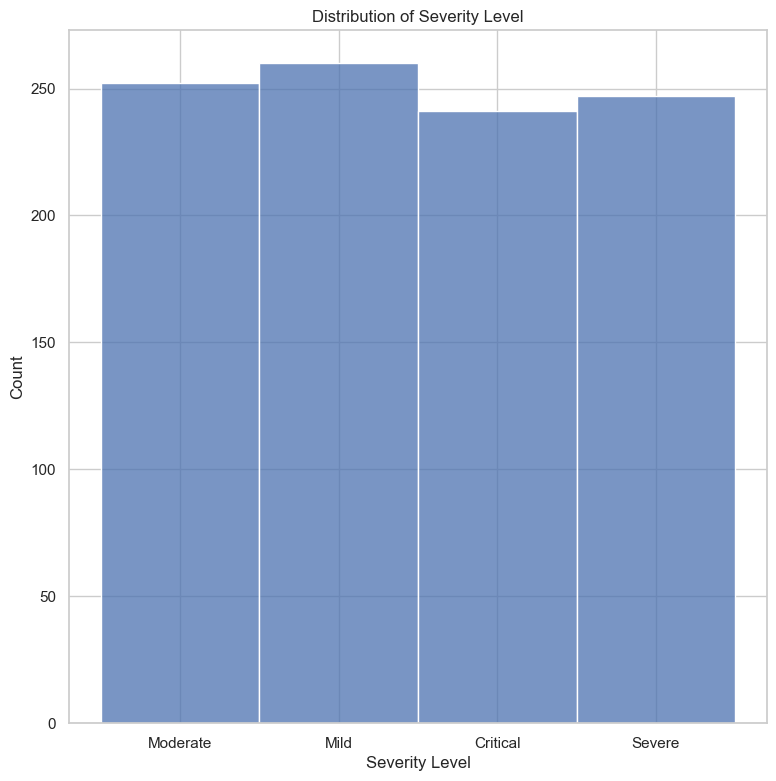

In [41]:
plt.figure(figsize = (9,9))
sns.histplot(data = covid,
            x = 'severity_level');

plt.title('Distribution of Severity Level')
plt.xlabel('Severity Level')
plt.show()

> This histogram shows the distribution of COVID-19 severity levels, helping us understand which severity category is most common. This helps detect class imbalances, which is crucial for training fair and accurate machine learning models

## Baseline Model 🤖

In [44]:
covid.drop(columns = ['country', 'month_year'], inplace = True)

In [45]:
covid['severity_level'].value_counts(normalize = True)

severity_level
Mild        0.260
Moderate    0.252
Severe      0.247
Critical    0.241
Name: proportion, dtype: float64

> Using our baseline model as a reference point, we are going to determine if our model is learning from the data. We want our model to perform better than **26%** Since the values are close to each other, it suggests that the dataset is relatively balanced across severity levels.

## Train Split Test

In [48]:
# Encode severity level as a numeric target variable
encoder = LabelEncoder()
y = encoder.fit_transform(covid["severity_level"])

In [49]:
X = covid.drop(columns = 'severity_level')

In [50]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)

In [51]:
sc = StandardScaler()

In [52]:
#Fit and Transform
X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.transform(X_test)

## Predicting Model

### Random Forest Classification

In [55]:
rf = RandomForestClassifier()
#Fit on training Data
rf.fit(X_train_sc, y_train)

RandomForestClassifier()

In [56]:
rf.score(X_train_sc, y_train)

1.0

In [57]:
rf.score(X_test_sc, y_test)

0.245

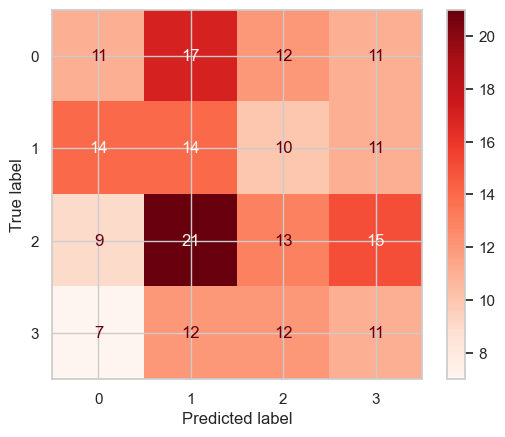

In [58]:
ConfusionMatrixDisplay.from_estimator(rf, X_test_sc, y_test, cmap='Reds');

> Our train score of 1.0 and test score of 0.27 indicate severe overfitting, meaning the model memorized training data but fails on new data. To fix this, we can reduce model complexity by limiting tree depth and increasing min_samples_split and min_samples_leaf to prevent overly small nodes. Lowering the number of trees (n_estimators) and enabling bootstrap sampling can also improve generalization.

### Random Forest Regressor

In [61]:
model = RandomForestRegressor(n_estimators=100, max_depth= 30, random_state=42)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

In [62]:
# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_pred)

mae

0.9564213392857143

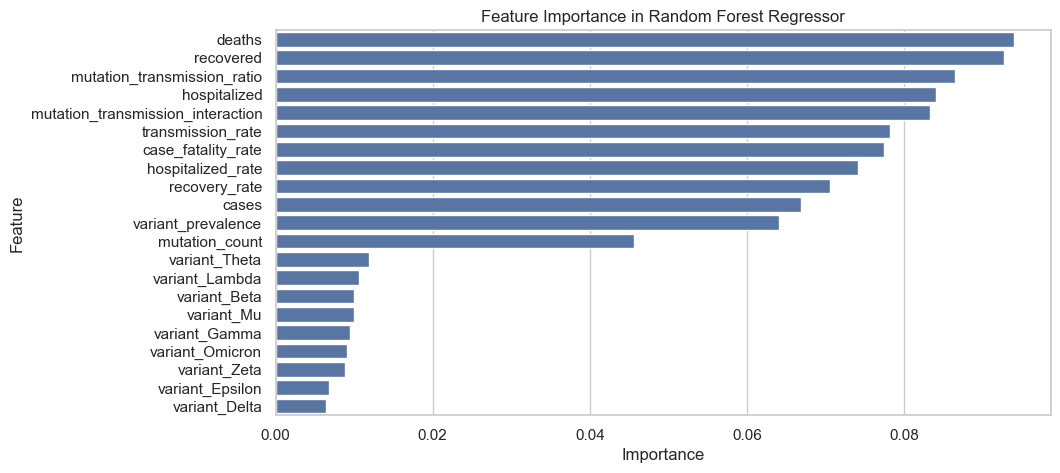

In [63]:
# Get feature importance
feature_importances = model.feature_importances_
features = X.columns

# Create DataFrame
importance_df = pd.DataFrame({"Feature": features, "Importance": feature_importances})
importance_df = importance_df.sort_values(by="Importance", ascending=False)

# Plot feature importance
plt.figure(figsize=(10,5))

sns.barplot(x= importance_df["Importance"], 
            y=importance_df["Feature"])

plt.title("Feature Importance in Random Forest Regressor")
plt.show()

> Our Random Forest Regressor model gave a MAE score of 0.95, meaning that the model’s severity predictions are off by nearly one severity category on average. To improve accuracy, we can focus on feature selection by identifying the most important factors  and removing weak predictors.

### Random Forest Regressor (using features)

In [66]:
features = ["case_fatality_rate", "hospitalized_rate", "variant_prevalence", 
            "transmission_rate", "recovery_rate", "mutation_transmission_ratio","deaths", 
            "recovered", "hospitalized", "mutation_transmission_interaction"]
X = covid[features]

encoder = LabelEncoder()
y = encoder.fit_transform(covid["severity_level"])

In [67]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)

In [68]:
model = RandomForestRegressor(n_estimators=100, max_depth= 30, random_state=42)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

In [69]:
# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_pred)

mae

0.9400499999999999

> Our Random Forest Regressor still has a MAE of 0.94, suggesting possible overfitting or missing key predictors. To improve performance, we can try scaling the data and reducing model complexity by limiting tree depth and increasing minimum samples per split. Since Random Forest may not capture complex feature interactions, testing **XGBoost** could improve predictions.

In [3]:
#Calculate the mean squared error and r2 to provide better understanding of accuracy
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse:.4f}")
print(f"R² Score: {r2:.4f}")

NameError: name 'mean_squared_error' is not defined

> Our model is underperforming, with an MSE of 1.1815 and a negative R² score (-0.0030), meaning it fails to capture meaningful patterns in this dataset. The R² score of -0.0030 indicates that the model is barely better than guessing the mean severity level. This suggests that while the model has reduced its prediction errors, it struggles to capture meaningful patterns in the data. The goal should be to reduce MSE below 1.0 while improving R² closer to 1.0. We can try hyperparameter tuning. 

### XGBoost Model

In [74]:
model = xgb.XGBClassifier(objective='binary:logistic', # For binary classification
                              n_estimators=100,        # Number of boosting rounds
                              learning_rate=0.1,       # Step size shrinkage 
                              max_depth=3)             # Maximum depth of a tree
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [75]:
y_pred = model.predict(X_test)

In [76]:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.255


> Our XGBoost model's accuracy of 25.5% and suggest it struggles to differentiate severity levels and may be predicting randomly. One issue could be class imbalance, so adjusting class weights can help ensure the model does not favor common severity levels.

## Summary

This project aimed to analyze this COVID-19 public health dataset to determine which factors contribute to a variant's severity. Through correlation analysis and feature engineering, we identified key predictors such as Case Fatality Rate, Hospitalization Rate, and Mutation Count as strong indicators of variant severity. We tested multiple machine learning models, including Random Forest and XGBoost, but faced challenges with overfitting and low predictive accuracy. We applied feature selection techniques  to improve model performance, but results indicated that severity classification is complex and may require additional data. Ultimately, this analysis provides valuable insights for public health decision-makers, helping them anticipate severe variants and allocate healthcare resources accordingly. 